# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [205]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [206]:
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

1. What the dataset looks like?
2. What are the data types?
3. Which columns contain the features of the websites?
4. Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
5. Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [207]:
# 1
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [208]:
# 2
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1781 non-null   object 
 4   SERVER                     1780 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1781 non-null   object 
 7   WHOIS_STATEPRO             1781 non-null   object 
 8   WHOIS_REGDATE              1781 non-null   object 
 9   WHOIS_UPDATED_DATE         1781 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

In [209]:
websites.describe()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781.000000,1781.000000,969.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
mean,56.961258,11.111735,11726.927761,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,27.555586,4.549896,36391.809051,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,39.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,49.000000,10.000000,1853.000000,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,68.000000,13.000000,11323.000000,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000
max,249.000000,43.000000,649263.000000,1194.000000,708.000000,17.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,2.362906e+06,1198.000000,20.000000,1.000000


In [210]:
# 3
features = websites.drop('Type', axis = 1)
features.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0


In [211]:
# 4
target = websites['Type']
target

0       1
1       0
2       0
3       0
4       0
       ..
1776    1
1777    1
1778    0
1779    0
1780    0
Name: Type, Length: 1781, dtype: int64

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [212]:
# 1
corr = websites.corr()
corr[corr >= 0.9]

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONTENT_LENGTH,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCP_CONVERSATION_EXCHANGE,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.997796,0.990848,NaN,NaN,0.997796,NaN,NaN
DIST_REMOTE_TCP_PORT,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REMOTE_IPS,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APP_BYTES,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.999992,NaN,NaN,NaN
SOURCE_APP_PACKETS,NaN,NaN,NaN,0.997796,NaN,NaN,NaN,1.000000,0.989285,NaN,NaN,1.000000,NaN,NaN
REMOTE_APP_PACKETS,NaN,NaN,NaN,0.990848,NaN,NaN,NaN,0.989285,1.000000,NaN,NaN,0.989285,NaN,NaN
SOURCE_APP_BYTES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


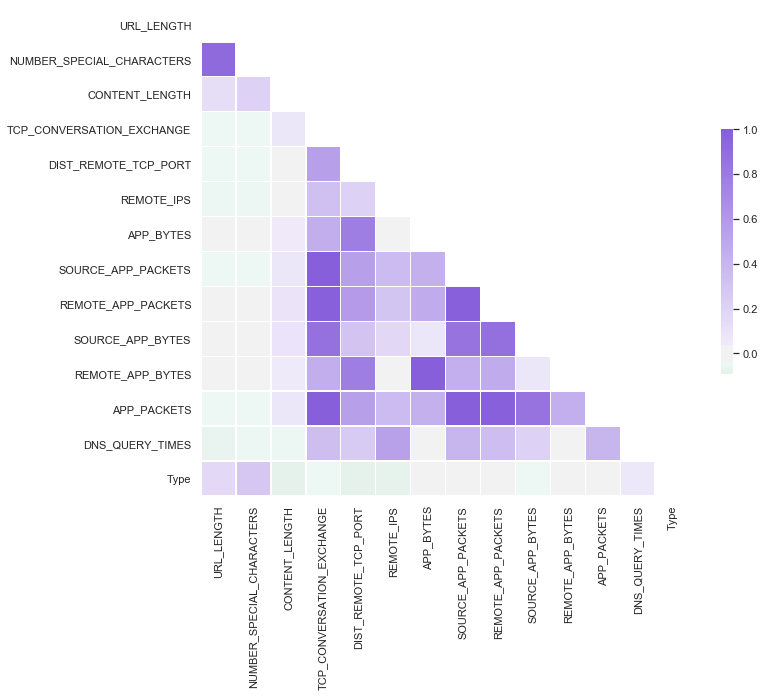

In [213]:
# 2
def corr_plot(correlation):
    
    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(150, 275, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.show()

corr_plot(corr)


The features with stronger correlation with the target varable are:
 - URL_LENGTH
 - NUMBER_SPECIAL_CHARACTERS

But they are also vert strongly correlated between themselves

Not so strongly correlated but still with some correlation we have:
- CONTENT_LENGTH
- DIST_REMOTE_TCP_PORT
- REMOTE_IPS
- DNS_QUERY_TIMES


Features with high collinearity are:
- APP_PACKETS & A FEW FEATURES



So we could remove **APP_PACKETS** and check if there's another feature with strong collinearity




# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [214]:
websites = websites.drop('APP_PACKETS', axis =1)

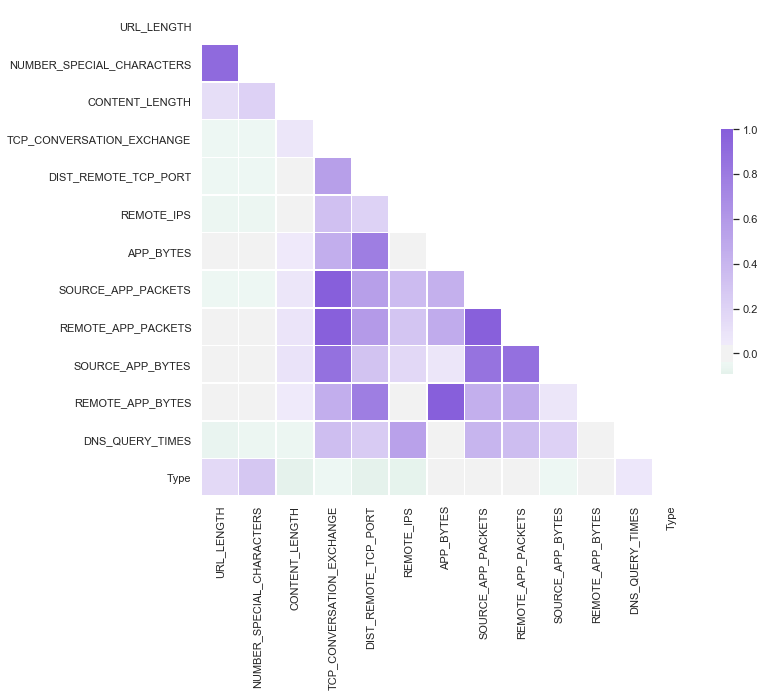

In [215]:
corr_plot(websites.corr())


In [216]:
websites = websites.drop('TCP_CONVERSATION_EXCHANGE', axis =1)
'''
We still have TCP_CONVERSATION_EXCHANGE highly correlatied with several features so I droped that column too
'''

'\nWe still have TCP_CONVERSATION_EXCHANGE highly correlatied with several features so I droped that column too\n'

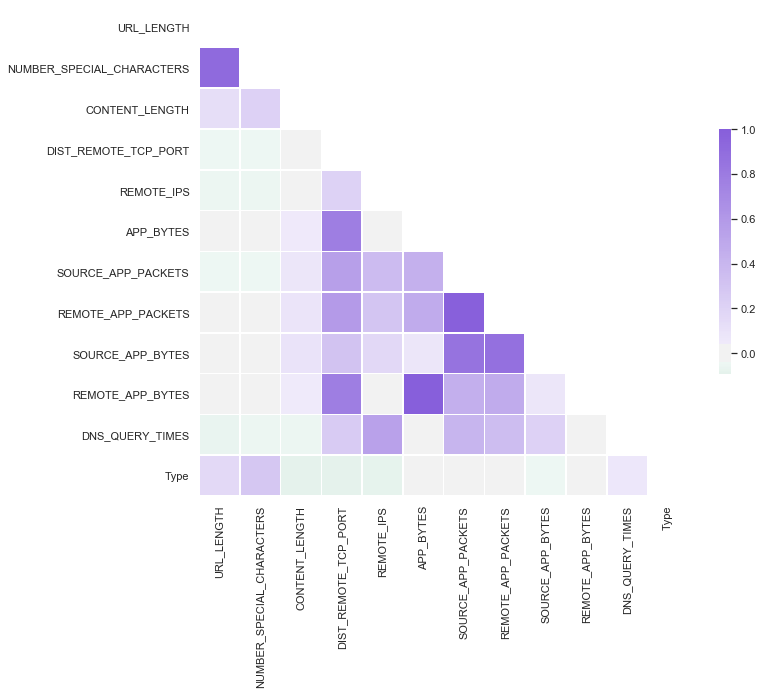

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONTENT_LENGTH,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DIST_REMOTE_TCP_PORT,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REMOTE_IPS,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
APP_BYTES,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.999992,NaN,NaN
SOURCE_APP_PACKETS,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.989285,NaN,NaN,NaN,NaN
REMOTE_APP_PACKETS,NaN,NaN,NaN,NaN,NaN,NaN,0.989285,1.000000,NaN,NaN,NaN,NaN
SOURCE_APP_BYTES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
REMOTE_APP_BYTES,NaN,NaN,NaN,NaN,NaN,0.999992,NaN,NaN,NaN,1.000000,NaN,NaN


In [217]:
corr_plot(websites.corr())
websites.corr()[websites.corr()>= .9]

In [218]:
websites = websites.drop('REMOTE_APP_BYTES', axis =1)
'''
REMOTE_APP_BYTES has a very strong correlation with APP_BYTES (99%) so we drop it
'''

'\nREMOTE_APP_BYTES has a very strong correlation with APP_BYTES (99%) so we drop it\n'

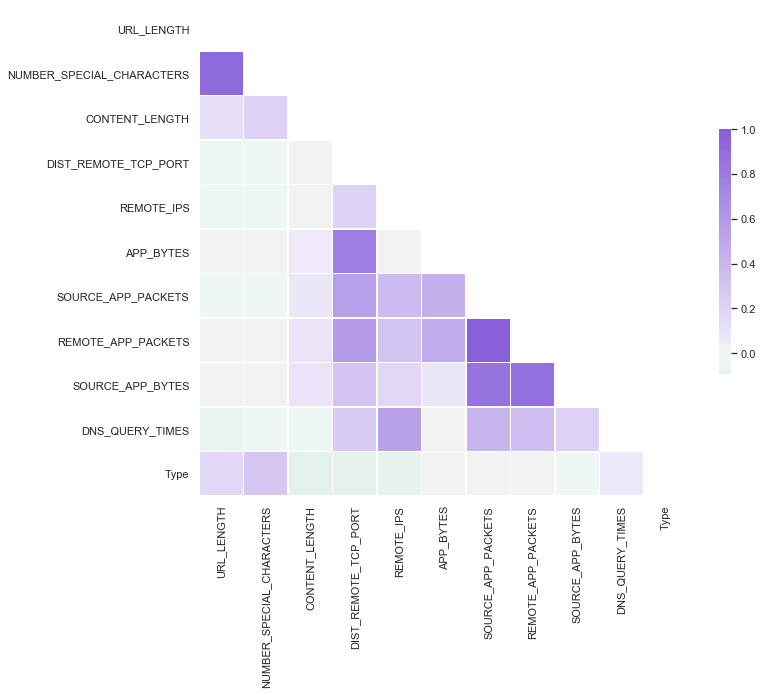

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONTENT_LENGTH,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DIST_REMOTE_TCP_PORT,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REMOTE_IPS,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
APP_BYTES,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
SOURCE_APP_PACKETS,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.989285,NaN,NaN,NaN
REMOTE_APP_PACKETS,NaN,NaN,NaN,NaN,NaN,NaN,0.989285,1.000000,NaN,NaN,NaN
SOURCE_APP_BYTES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
DNS_QUERY_TIMES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [219]:
corr_plot(websites.corr())
websites.corr()[websites.corr()>= .9]

In [220]:
websites = websites.drop('REMOTE_APP_PACKETS', axis =1)
'''
Last one, REMOTE_APP_PACKETS and SOURCE_APP_PACKETS
'''

'\nLast one, REMOTE_APP_PACKETS and SOURCE_APP_PACKETS\n'

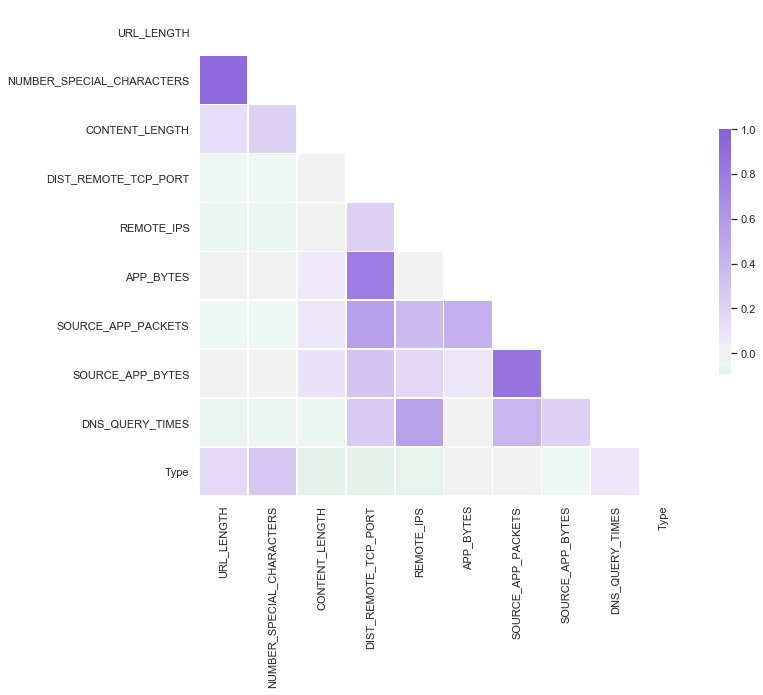

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,SOURCE_APP_BYTES,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.917986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUMBER_SPECIAL_CHARACTERS,0.917986,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CONTENT_LENGTH,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DIST_REMOTE_TCP_PORT,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
REMOTE_IPS,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
APP_BYTES,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
SOURCE_APP_PACKETS,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
SOURCE_APP_BYTES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
DNS_QUERY_TIMES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [221]:
corr_plot(websites.corr())
websites.corr()[websites.corr()>= .9]

In [222]:
'''
We could also drop URL_LENGTH that is strongly correlated with NUMBER_SPECIAL_CHARACTERS but I'll keep it for now
'''

"\nWe could also drop URL_LENGTH that is strongly correlated with NUMBER_SPECIAL_CHARACTERS but I'll keep it for now\n"

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [223]:
websites.isna().sum()

URL                            0
URL_LENGTH                     0
NUMBER_SPECIAL_CHARACTERS      0
CHARSET                        0
SERVER                         1
CONTENT_LENGTH               812
WHOIS_COUNTRY                  0
WHOIS_STATEPRO                 0
WHOIS_REGDATE                  0
WHOIS_UPDATED_DATE             0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
APP_BYTES                      0
SOURCE_APP_PACKETS             0
SOURCE_APP_BYTES               0
DNS_QUERY_TIMES                1
Type                           0
dtype: int64

In [224]:
print('Missing values in CONTENT_LENGTH col:', websites.isna().sum()['CONTENT_LENGTH']/websites.shape[0]*100,'%')

Missing values in CONTENT_LENGTH col: 45.59236384053902 %


If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [225]:
websites.drop('CONTENT_LENGTH', axis=1, inplace = True)

In [226]:
websites.shape

(1781, 16)

In [227]:
websites.dropna(inplace=True)

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [228]:
websites.isna().sum()

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
SOURCE_APP_BYTES             0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [229]:
websites['WHOIS_COUNTRY'].value_counts()

US                1102
None               306
CA                  83
ES                  63
AU                  35
PA                  21
GB                  19
JP                  11
CN                  10
UK                  10
IN                  10
FR                   9
CZ                   9
NL                   6
CH                   6
[u'GB'; u'UK']       5
KR                   5
BS                   4
AT                   4
ru                   4
PH                   4
HK                   3
BE                   3
TR                   3
KY                   3
DE                   3
SE                   3
us                   3
SC                   3
KG                   2
NO                   2
UY                   2
IL                   2
RU                   2
Cyprus               2
UA                   2
SI                   2
BR                   2
IE                   1
LV                   1
IT                   1
se                   1
UG                   1
United King

In [230]:
websites.loc[websites['WHOIS_COUNTRY'] == 'Cyprus', 'WHOIS_COUNTRY'] = 'CY'
websites.loc[websites['WHOIS_COUNTRY'] == 'United Kingdom', 'WHOIS_COUNTRY'] = 'GB'
websites.loc[websites['WHOIS_COUNTRY'] == "[u'GB'; u'UK']", 'WHOIS_COUNTRY'] = 'GB'
websites.loc[websites['WHOIS_COUNTRY'] == 'us', 'WHOIS_COUNTRY'] = 'US'
websites.loc[websites['WHOIS_COUNTRY'] == 'se', 'WHOIS_COUNTRY'] = 'SE'

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

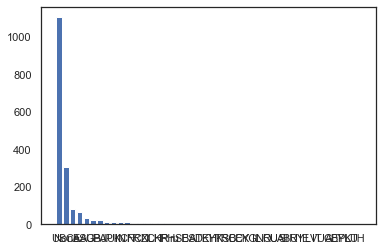

In [231]:
plt.bar(websites['WHOIS_COUNTRY'].value_counts().index,websites['WHOIS_COUNTRY'].value_counts().values)
plt.show()

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [232]:
top_10 = list(websites['WHOIS_COUNTRY'].value_counts()[:10].index)
top_10

['US', 'None', 'CA', 'ES', 'AU', 'GB', 'PA', 'JP', 'UK', 'IN']

In [233]:
websites.loc[~websites['WHOIS_COUNTRY'].isin(top_10), 'WHOIS_COUNTRY'] = 'OTHER'

In [234]:
websites['WHOIS_COUNTRY'].value_counts()

US       1105
None      306
OTHER     110
CA         83
ES         63
AU         35
GB         25
PA         21
JP         11
UK         10
IN         10
Name: WHOIS_COUNTRY, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [235]:
websites.drop(['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'],axis=1, inplace= True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [236]:
websites.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1779 non-null   object 
 1   URL_LENGTH                 1779 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1779 non-null   int64  
 3   CHARSET                    1779 non-null   object 
 4   SERVER                     1779 non-null   object 
 5   WHOIS_COUNTRY              1779 non-null   object 
 6   DIST_REMOTE_TCP_PORT       1779 non-null   int64  
 7   REMOTE_IPS                 1779 non-null   int64  
 8   APP_BYTES                  1779 non-null   int64  
 9   SOURCE_APP_PACKETS         1779 non-null   int64  
 10  SOURCE_APP_BYTES           1779 non-null   int64  
 11  DNS_QUERY_TIMES            1779 non-null   float64
 12  Type                       1779 non-null   int64  
dtypes: float64(1), int64(8), object(4)
memory usage:

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [237]:
websites.drop('URL',axis=1,inplace=True)


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [238]:
websites['CHARSET'].value_counts()

UTF-8           674
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
None              7
ISO-8859          1
windows-1251      1
windows-1252      1
Name: CHARSET, dtype: int64

In [239]:
websites['SERVER'].value_counts()

Apache                                                                      385
nginx                                                                       211
None                                                                        175
Microsoft-HTTPAPI/2.0                                                       113
cloudflare-nginx                                                             94
                                                                           ... 
lighttpd                                                                      1
mw2171.codfw.wmnet                                                            1
Apache/2.2.11 (Unix) PHP/5.2.6                                                1
Apache/2.2.21 (Unix) mod_ssl/2.2.21 OpenSSL/0.9.8e-fips-rhel5 PHP/5.3.10      1
lighttpd/1.4.28                                                               1
Name: SERVER, Length: 239, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [240]:
'''
I would group them by name "Apache, nginx, ... "
'''


'\nI would group them by name "Apache, nginx, ... "\n'

![Think Hard](../images/think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [241]:
websites.loc[websites['SERVER'].str.contains('Apache'),'SERVER'] = 'Apache'
websites.loc[websites['SERVER'].str.contains('Microsoft'),'SERVER'] = 'Microsoft'
websites.loc[websites['SERVER'].str.contains('nginx'),'SERVER'] = 'nginx'

In [242]:
websites.loc[~websites['SERVER'].isin(['Apache','Microsoft','nginx']), 'SERVER'] = 'Other'

In [243]:
websites['SERVER'].value_counts()

Apache       642
Other        504
nginx        435
Microsoft    198
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [244]:
websites.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL_LENGTH                 1779 non-null   int64  
 1   NUMBER_SPECIAL_CHARACTERS  1779 non-null   int64  
 2   CHARSET                    1779 non-null   object 
 3   SERVER                     1779 non-null   object 
 4   WHOIS_COUNTRY              1779 non-null   object 
 5   DIST_REMOTE_TCP_PORT       1779 non-null   int64  
 6   REMOTE_IPS                 1779 non-null   int64  
 7   APP_BYTES                  1779 non-null   int64  
 8   SOURCE_APP_PACKETS         1779 non-null   int64  
 9   SOURCE_APP_BYTES           1779 non-null   int64  
 10  DNS_QUERY_TIMES            1779 non-null   float64
 11  Type                       1779 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 180.7+ KB


In [245]:
website_dummy = pd.get_dummies(websites)

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [247]:
website_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 0 to 1780
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL_LENGTH                 1779 non-null   int64  
 1   NUMBER_SPECIAL_CHARACTERS  1779 non-null   int64  
 2   DIST_REMOTE_TCP_PORT       1779 non-null   int64  
 3   REMOTE_IPS                 1779 non-null   int64  
 4   APP_BYTES                  1779 non-null   int64  
 5   SOURCE_APP_PACKETS         1779 non-null   int64  
 6   SOURCE_APP_BYTES           1779 non-null   int64  
 7   DNS_QUERY_TIMES            1779 non-null   float64
 8   Type                       1779 non-null   int64  
 9   CHARSET_ISO-8859           1779 non-null   uint8  
 10  CHARSET_ISO-8859-1         1779 non-null   uint8  
 11  CHARSET_None               1779 non-null   uint8  
 12  CHARSET_UTF-8              1779 non-null   uint8  
 13  CHARSET_iso-8859-1         1779 non-null   uint8

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [253]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(website_dummy.drop('Type',axis = 1), website_dummy['Type'], test_size = 0.2)

In [259]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1423, 32)
(356, 32)
(1423,)
(356,)


#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [300]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 5000)

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [301]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [302]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 

In [303]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [306]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9248067463106114
0.9410112359550562


In [304]:
confusion_matrix(y_pred,y_test)

array([[311,  19],
       [  2,  24]])

||Positive|Negative|
|--------|---------------|---------------|
|**Positive**| TRUE POSITIVE | FALSE POSITIVE|
|**Negative**| FALSE NEGATIVE |  TRUE NEGATIVE|

In [307]:
accuracy_score(y_pred,y_test)

0.9410112359550562

In [308]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       313
           1       0.92      0.56      0.70        43

    accuracy                           0.94       356
   macro avg       0.93      0.78      0.83       356
weighted avg       0.94      0.94      0.93       356



What are your thoughts on the performance of the model? Write your conclusions below.

In [309]:
# Your conclusions here:
'''
Not bad, regarding the confusion matrix, false negatives are the once I would be more worried about and its the lowest number and accuracy is good too.

'''


'\nNot bad, regarding the confusion matrix, false negatives are the once I would be more worried about and its the lowest number and accuracy is good too.\n\n'

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [311]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [314]:
y_pred = model.predict(X_test)

In [329]:
print('Model Scores')
print('Train:',model.score(X_train, y_train))
print('Test:',model.score(X_test, y_test))
print('\n')
print("Confusion Matrix:\n",confusion_matrix(y_pred,y_test))
print('\n')
print("Accuracy Score:\n",accuracy_score(y_pred,y_test))
print('\n')
print("Classification report:\n",classification_report(y_test, y_pred))

Model Scores
Train: 0.955024595924104
Test: 0.9382022471910112


Confusion Matrix:
 [[301  10]
 [ 12  33]]


Accuracy Score:
 0.9382022471910112


Classification report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       313
           1       0.73      0.77      0.75        43

    accuracy                           0.94       356
   macro avg       0.85      0.86      0.86       356
weighted avg       0.94      0.94      0.94       356



#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [330]:
model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [331]:
print('Model Scores')
print('Train:',model.score(X_train, y_train))
print('Test:',model.score(X_test, y_test))
print('\n')
print("Confusion Matrix:\n",confusion_matrix(y_pred,y_test))
print('\n')
print("Accuracy Score:\n",accuracy_score(y_pred,y_test))
print('\n')
print("Classification report:\n",classification_report(y_test, y_pred))

Model Scores
Train: 0.9451862262825017
Test: 0.9438202247191011


Confusion Matrix:
 [[302   9]
 [ 11  34]]


Accuracy Score:
 0.9438202247191011


Classification report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       313
           1       0.76      0.79      0.77        43

    accuracy                           0.94       356
   macro avg       0.86      0.88      0.87       356
weighted avg       0.95      0.94      0.94       356



Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [332]:
'''
Yup
'''

'\nYup\n'

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [38]:
# Your code here